In [ ]:
# enable this to download the file if not already present

#!wget http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/Keri_3D/Kerry3D.segy

In [1]:
import numpy as np
from numba import vectorize, cuda
from struct import unpack
from ibm2ieee import ibm2float32 as i2f
import segyio
from segyio import _segyio
import cupy as cp
%config Completer.use_jedi = False

In [2]:
class ReadBinHdr(object):

    ''' Read binary trace header for a trace '''

    def __init__(self, bh):
        if len(bh) != 400:
            print("Binary header should be 400 bytes long")
        else:
            self.jobid = unpack(">i", bh[0:4])[0]
            self.line = unpack(">i", bh[4:8])[0]
            self.reel = unpack(">i", bh[8:12])[0]
            self.numtrcens = unpack(">h", bh[12:14])[0]
            self.numauxtrcs = unpack(">h", bh[14:16])[0]
            self.sampint = unpack(">h", bh[16:18])[0]
            self.sampint2 = unpack(">h", bh[18:20])[0]
            self.samppertrc = unpack(">h", bh[20:22])[0]
            self.samppertrc2 = unpack(">h", bh[22:24])[0]
            self.datasampcode = unpack(">h", bh[24:26])[0]
            self.ensfold = unpack(">h", bh[26:28])[0]
            self.sortcode = unpack(">h", bh[28:30])[0]
            self.dis_units = unpack(">h", bh[54:56])[0]
            self.segyformat = unpack(">h", bh[300:302])[0] // 256
            self.lengthflag = unpack(">h", bh[302:304])[0]
            self.numexthdrs = unpack(">h", bh[304:306])[0]
    
class ReadTrcHdr(object):
    ''' Read Trace header '''
    def __init__(self, bh):
        if len(bh) != 240:
            print("Trace Header should be 240 bytes long")
        else:
            self.inline = unpack(">i", bh[220:224])[0]
            self.xline = unpack(">i", bh[20:24])[0]
            self.sou_x = unpack(">i", bh[72:76])[0]
            self.sou_y = unpack(">i", bh[76:80])[0]

In [3]:
%%time
hdrs = []
trcs = []
with open("../Kerry3D.segy","rb") as f:
    EBCDIC = f.read(3200)
    BIN = ReadBinHdr(f.read(400))
    samples_per_trace = BIN.samppertrc
    sample_interval = BIN.sampint
    idx=1
    print("Starting loop....")
    while True:
        tmp = f.read(240)
        if not tmp:
            print("End scanning .......")
            break
        hdr = ReadTrcHdr(tmp).__dict__
        trc = f.read(samples_per_trace*4)
#         arr = ibmtoieee(np.frombuffer(trc,dtype='>u4'))
        hdrs.append(hdr)
        trcs.append(trc)
        idx+=1
data = trcs[10000] #data to perform analysis on
data[:100]

Starting loop....
End scanning .......
CPU times: user 676 ms, sys: 585 ms, total: 1.26 s
Wall time: 2.08 s


b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbf\x94\xb9_\xc0\x1b\xe2\xc2\xc0J\\\xb0\xc0f?r\xc0x\xd6\x9d\xc0\x8bm\xc9\xc0\x94\xb9_\xc0\x94\xb9_\xc0S\xa8F@\x8bm\xc9A\x1d\xa0\xeeA%.XA\x12\x97,\xc0.y\xee\xc0\x1b\xe2\xc2@\x82"3\x00\x00\x00\x00\xc1\x10DF\xc1\x18fj'

In [4]:
# the Cuda Kernel code that runs on every unsigned int in array
ibm32cupy = cp.RawKernel(r'''
extern "C" __global__
void ibm32cupy(const unsigned int* x1, float* y) {
    int tid = blockDim.x * blockIdx.x + threadIdx.x;
    unsigned int x = x1[tid];
    if (x != 0){
        int sign = ((x1[tid] >> 31) & 0x01) * (-2) + 1;
        int exponent = (x1[tid] >> 24) & 0x7F;
        int tmp = 4 * (exponent - 64);
        double p;
        if (tmp < 0) {
            int po2 = 1 << (abs(tmp));
            p = (double)(1.0/po2);
        }
        else{
            p = 1 << tmp;
        }
        int mantissa = x1[tid] & 0x00ffffff;
        float frac = ((float)mantissa / 0x1000000);
        y[tid] = sign * frac * p;
    }
    else{
        y[tid] = 0.0;
    }    
}
''', 'ibm32cupy')
# vectorized version of regular python function
@vectorize(['float32(uint32)'])
def ibmpy_vec(data):
    if data == 0:
        return 0.0
    sign = data >> 31 & 0x01
    exponent = data >> 24 & 0x7f
    mantissa = (data & 0x00ffffff) / float(pow(2, 24))
    return (1 - 2 * sign) * mantissa * pow(16.0, exponent - 64)

#reguar python
def ibmpython(data):
    if data == 0:
        return 0.0
    sign = data >> 31 & 0x01
    exponent = data >> 24 & 0x7f
    mantissa = (data & 0x00ffffff) / float(pow(2, 24))
    return (1 - 2 * sign) * mantissa * pow(16.0, exponent - 64)

In [5]:
# intuitive first attempt of converting. apply a function to every element of an array in loop
%timeit np.array([ibmpython(x) for x in np.frombuffer(data,dtype=">u4")],dtype=np.float32)

5.58 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
#vectorized version of previous attempt. 
%timeit np.vectorize(ibmpython)(np.frombuffer(data,dtype='>u4'))

309 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
# uses the current industry method of segyio module
n = 10001
d = np.memmap('../Kerry3D.segy', offset = 3600, dtype = np.uint32)
st = n*60+(n-1)*samples_per_trace
end = n*(60+samples_per_trace)
%timeit segyio.tools.native(d[st:end])

8.54 µs ± 6.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
d.close()

AttributeError: 'memmap' object has no attribute 'close'

In [9]:
#uses pypi module ibm2ieee which is cython under the hood. https://pypi.org/project/ibm2ieee/
%timeit i2f(np.frombuffer(data,dtype=">u4"))

3.85 µs ± 11 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%timeit ibmpy_vec(np.frombuffer(data,dtype=">u4"))

3.15 µs ± 9.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
# uses cupy with a raw kernel wriiten in cuda. memory output must be preallocated
x1 = cp.array(np.frombuffer(data,dtype='>u4'),dtype=cp.uint32)
arr = cp.zeros(x1.size, dtype=cp.float32)
%timeit ibm32cupy((x1.size,), (1,), (x1, arr))

2.74 µs ± 2.78 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
times_for_regular_python = []
def ff1(trcs,n):
    for i in range(10000,10000+n):
        np.array([ibmpython(x) for x in np.frombuffer(trcs[i],dtype=">u4")],dtype=np.float32)
for n in range(1,1000,10):
    tim0 = %timeit -o -n 1 -r 3 ff1(trcs,n)
    times_for_regular_python.append((n, tim0.average,tim0.stdev))
times_for_regular_python

5.81 ms ± 64.3 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
109 ms ± 516 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
264 ms ± 615 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
420 ms ± 863 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
575 ms ± 1.03 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
737 ms ± 2.31 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
884 ms ± 3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.04 s ± 1.39 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.21 s ± 2.92 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.36 s ± 2.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.51 s ± 3.55 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.67 s ± 4.02 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.81 s ± 3.55 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.98 s ± 5.49 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.15 s ± 2.98 ms per loop (mean ± std. dev. of 3 runs,

[(1, 0.005808621669226947, 6.425690200231129e-05),
 (11, 0.1085151346657464, 0.0005160991047758169),
 (21, 0.26436657666636165, 0.0006146394889858141),
 (31, 0.4204946353347623, 0.000863440131557714),
 (41, 0.5745256873318189, 0.001028027686587637),
 (51, 0.7370943296676463, 0.0023062610974723848),
 (61, 0.8841755419998663, 0.002998254555502252),
 (71, 1.0412400416656358, 0.0013926784257618232),
 (81, 1.2055896059998001, 0.0029196032515929264),
 (91, 1.3585095626694965, 0.002903736733816862),
 (101, 1.511758382669844, 0.003551267309721897),
 (111, 1.6663282993346609, 0.004016564014802121),
 (121, 1.8137845106660582, 0.003553848625941242),
 (131, 1.983448180333653, 0.005492607685991864),
 (141, 2.145140595998479, 0.002979107071909006),
 (151, 2.283732458667752, 0.0032517750465849934),
 (161, 2.4485606129989415, 0.0020414181815898917),
 (171, 2.6060623623319166, 0.002551850411592792),
 (181, 2.7503207860014904, 0.001996943248715319),
 (191, 2.9223538626683876, 0.0009399359437782159),
 (2

In [13]:
times_for_vectorize_python=[]
def ff2(trcs,n):
    for i in range(10000,10000+n):
        np.vectorize(ibmpython)(np.frombuffer(trcs[i],dtype='>u4'))
for n in range(1,1000,10):
    tim1 = %timeit -o -n 10 -r 7 ff2(trcs,n)
    times_for_vectorize_python.append((n, tim1.average,tim1.stdev))

361 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.42 ms ± 73.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
13 ms ± 378 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.3 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.8 ms ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.3 ms ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.8 ms ± 80.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.7 ms ± 605 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
58 ms ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
65.5 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
73.1 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
81.6 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
89.1 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
95.1 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
103 ms ± 277 µs pe

In [14]:
d._mmap.close()

In [20]:
times_for_segyio = []
def ff3(d,n):
    for i in range(10000,10000+n):
        st = n*60+(n-1)*samples_per_trace
        end = n*(60+samples_per_trace)
        segyio.tools.native(d[st:end])
dmap = np.memmap('../Kerry3D.segy', offset = 3600, dtype = np.uint32)
for n in range(1,1000,10):
    tim2 = %timeit -o -n 10 -r 7 ff3(dmap,n)
    times_for_segyio.append((n, tim2.average,tim2.stdev))
dmap._mmap.close()
times_for_segyio

12.6 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
102 µs ± 4.69 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
191 µs ± 5.98 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
272 µs ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
375 µs ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
446 µs ± 8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
567 µs ± 97.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
629 µs ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
972 µs ± 132 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
797 µs ± 26 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
999 µs ± 196 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.1 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.28 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.17 ms ± 95.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.29 ms ± 168 µs per loop (

[(1, 1.2562114300505658e-05, 6.217453884771596e-06),
 (11, 0.00010219121426676533, 4.693903332594435e-06),
 (21, 0.00019089087145403026, 5.975129494796333e-06),
 (31, 0.00027155044278645487, 3.903694817393188e-06),
 (41, 0.0003751185144730178, 2.086004366098535e-05),
 (51, 0.00044576941446783684, 8.002366000593721e-06),
 (61, 0.0005672418714051934, 9.712864808536399e-05),
 (71, 0.0006289930857227384, 3.3141634000182554e-05),
 (81, 0.0009721162000330098, 0.000132205492358323),
 (91, 0.000796856185791382, 2.6010352174574225e-05),
 (101, 0.0009988814000930037, 0.00019565322081169378),
 (111, 0.0010977167142430387, 0.0001795549132843856),
 (121, 0.0012814558715035674, 0.0002391996238278262),
 (131, 0.0011688026571521604, 9.589397499385403e-05),
 (141, 0.0012896297144054968, 0.00016800363589008097),
 (151, 0.0013819265569119514, 0.00013364250250353892),
 (161, 0.0014144255284918473, 3.5050888925962175e-05),
 (171, 0.0015771897858940064, 0.00013123540653434476),
 (181, 0.0015669679428226247,

In [27]:
times_for_i2f=[]
def ff4(trcs,n):
    for i in range(10000,10000+n):
        i2f(np.frombuffer(trcs[i],dtype=">u4"))
for n in range(1,1000,10):
    tim3 = %timeit -o -n 100 -r 7 ff4(trcs,n)
    times_for_i2f.append((n, tim3.average,tim3.stdev))
times_for_i2f

5.16 µs ± 1.46 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
49.7 µs ± 1.36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
99.5 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
149 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
198 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
251 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
301 µs ± 2.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
350 µs ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
406 µs ± 4.55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
453 µs ± 3.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
508 µs ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
551 µs ± 3.94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
603 µs ± 4.69 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
652 µs ± 3.71 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
703

[(1, 5.1637714412728594e-06, 1.4629912730022277e-06),
 (11, 4.974374000864503e-05, 1.3595094682556247e-06),
 (21, 9.949521858028933e-05, 1.031054907806564e-06),
 (31, 0.00014913446999604015, 1.5144693099299933e-06),
 (41, 0.00019830007001084073, 1.9110687079353945e-06),
 (51, 0.0002514250499890685, 2.337557519818861e-06),
 (61, 0.0003007099842839774, 2.6646573100919704e-06),
 (71, 0.0003503176399993078, 2.526059740628217e-06),
 (81, 0.0004058457385690417, 4.553684581589005e-06),
 (91, 0.00045323971428193284, 3.908213099495692e-06),
 (101, 0.000508427304271858, 1.6518226541227542e-06),
 (111, 0.0005511680385721515, 3.937328509046336e-06),
 (121, 0.0006028728857095951, 4.694619860712202e-06),
 (131, 0.0006521580371398678, 3.70964237474137e-06),
 (141, 0.0007030211928629017, 4.512402411421632e-06),
 (151, 0.0007521302028596569, 3.502437102860401e-06),
 (161, 0.000799709861437025, 2.657422678972101e-06),
 (171, 0.0008540632828641848, 3.62397881472053e-06),
 (181, 0.0008995737400151223, 3.3

In [25]:
times_for_numba=[]
def ff5(trcs,n):
    for i in range(10000,10000+n):
        ibmpy_vec(np.frombuffer(trcs[i],dtype='>u4'))
for n in range(1,1000,10):
    tim4 = %timeit -o -n 100 -r 7 ff5(trcs,n)
    times_for_numba.append((n, tim4.average,tim4.stdev))
times_for_numba

4.84 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
62.1 µs ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
143 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
224 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
302 µs ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
382 µs ± 3.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
462 µs ± 4.02 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
542 µs ± 4.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
620 µs ± 3.75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
697 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
781 µs ± 4.14 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
861 µs ± 4.41 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
943 µs ± 4.73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.02 ms ± 4.48 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.1 

[(1, 4.835952859139069e-06, 1.94820171156731e-06),
 (11, 6.2094192866685e-05, 2.579876398075341e-06),
 (21, 0.00014337604713676098, 1.2082484615543158e-06),
 (31, 0.00022420826715201006, 1.5346391429016805e-06),
 (41, 0.00030167908856778273, 2.8508939042931865e-06),
 (51, 0.00038238195999708426, 3.6609736579672335e-06),
 (61, 0.00046176971142163634, 4.018437214037205e-06),
 (71, 0.0005422890357190876, 4.401666370602469e-06),
 (81, 0.0006198735514252414, 3.7547111589660308e-06),
 (91, 0.0006973228314226227, 3.283298975031034e-06),
 (101, 0.0007805625300014591, 4.137972830748599e-06),
 (111, 0.0008610518956993473, 4.411736423270721e-06),
 (121, 0.0009431182714407831, 4.726305932585617e-06),
 (131, 0.0010185680585813575, 4.481004923416849e-06),
 (141, 0.0010982748371627948, 4.687906591822141e-06),
 (151, 0.0011822179500034378, 5.853825545541398e-06),
 (161, 0.0012553075342813305, 5.469124302856434e-06),
 (171, 0.0013323734014453034, 6.127105311478761e-06),
 (181, 0.0014168425400047063, 6.

In [26]:
times_for_cupy = []
def ff6(trcs,n):
    x1 = cp.array([np.frombuffer(trcs[i],dtype='>u4') for i in range(10000,10000+n)],dtype=cp.uint32)
    arr = cp.zeros(x1.size, dtype=cp.float32).reshape(x1.shape)
    ibm32cupy((x1.size,), (1,), (x1, arr))
for n in range(1,1000,10):
    tim5 = %timeit -o -n 100 -r 7 ff6(trcs,n)
    times_for_cupy.append((n, tim5.average,tim5.stdev))
times_for_cupy

66.2 µs ± 31.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
93 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
131 µs ± 912 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
173 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
201 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
239 µs ± 2.82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
273 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
310 µs ± 5.73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
351 µs ± 4.51 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
387 µs ± 5.82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
426 µs ± 6.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
466 µs ± 6.05 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
497 µs ± 5.49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
531 µs ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
568 µs ±

[(1, 6.623054428408588e-05, 3.110431445553405e-05),
 (11, 9.29621185787255e-05, 2.0739208367428927e-06),
 (21, 0.00013070748429787012, 9.117880705029101e-07),
 (31, 0.00017287650855515884, 1.4152422198741208e-05),
 (41, 0.00020120347999701542, 1.4112366304514243e-06),
 (51, 0.0002387253428605618, 2.820566388844284e-06),
 (61, 0.000273034299991975, 1.6284840721203521e-06),
 (71, 0.00030958067429310177, 5.732959839446993e-06),
 (81, 0.0003510191642895474, 4.514680807419443e-06),
 (91, 0.0003866873285733163, 5.818748761878269e-06),
 (101, 0.0004264558171520808, 6.397200279454566e-06),
 (111, 0.00046572354714693835, 6.046154785694454e-06),
 (121, 0.0004965057842595602, 5.485813877974713e-06),
 (131, 0.0005311660671577556, 6.177526965550861e-06),
 (141, 0.000568407089989965, 6.882851694805793e-06),
 (151, 0.0006140108914405573, 1.0984651213606794e-05),
 (161, 0.0006358307785870107, 8.045779239059082e-06),
 (171, 0.0006830283800185759, 4.867672516012569e-06),
 (181, 0.00071823676285151, 6.06

In [28]:
final = []
for x in list(zip(times_for_regular_python,times_for_vectorize_python,times_for_segyio,times_for_i2f,times_for_numba,times_for_cupy)):
    tmp = [x[0][0]]
    for y in x:
        tmp.append(y[1])
    final.append(tmp)

In [29]:
import pandas as pd

In [30]:
df = pd.DataFrame(final, columns=["N","python","vec_python","segyio","i2f","numba","cupy"])

In [31]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'log10 total time (us)')

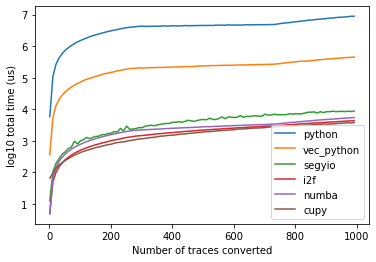

In [33]:
cols = df.columns[1:]
for col in cols:
    plt.plot(df["N"],np.log10(df[col]*1000000), label=col)
plt.legend()
plt.xlabel("Number of traces converted")
plt.ylabel("log10 total time (us)")

Text(0, 0.5, 'total time (ms)')

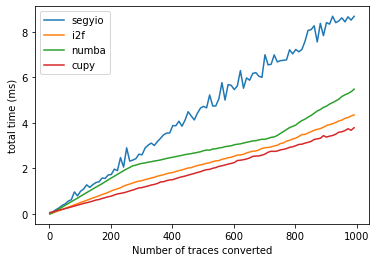

In [34]:
cols = df.columns[3:]
for col in cols:
    plt.plot(df["N"],df[col]*1000, label=col)
plt.legend()
plt.xlabel("Number of traces converted")
plt.ylabel("total time (ms)")

Text(0, 0.5, 'Log10 total time (us) ')

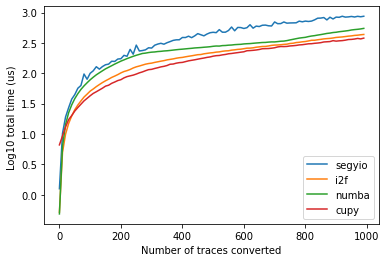

In [35]:
df2= df.copy()
for col in df2.columns[1:]:
    df2[col] = np.log10((df2[col])*100000)
for col in df2.columns[3:]:
    plt.plot(df2["N"],df2[col], label=col)
plt.legend()
plt.xlabel("Number of traces converted")
plt.ylabel("Log10 total time (us) ")

In [36]:
import json

In [37]:
final

[[1,
  0.005808621669226947,
  0.0003612562857077656,
  1.2562114300505658e-05,
  5.1637714412728594e-06,
  4.835952859139069e-06,
  6.623054428408588e-05],
 [11,
  0.1085151346657464,
  0.005418070357180634,
  0.00010219121426676533,
  4.974374000864503e-05,
  6.2094192866685e-05,
  9.29621185787255e-05],
 [21,
  0.26436657666636165,
  0.01297544405700007,
  0.00019089087145403026,
  9.949521858028933e-05,
  0.00014337604713676098,
  0.00013070748429787012],
 [31,
  0.4204946353347623,
  0.020287154000003024,
  0.00027155044278645487,
  0.00014913446999604015,
  0.00022420826715201006,
  0.00017287650855515884],
 [41,
  0.5745256873318189,
  0.027761504314340917,
  0.0003751185144730178,
  0.00019830007001084073,
  0.00030167908856778273,
  0.00020120347999701542],
 [51,
  0.7370943296676463,
  0.035252848742883154,
  0.00044576941446783684,
  0.0002514250499890685,
  0.00038238195999708426,
  0.0002387253428605618],
 [61,
  0.8841755419998663,
  0.042785039242673004,
  0.000567241871

In [38]:
with open("results.json","w") as jsonfile:
    jsonfile.write(json.dumps(final))